<a href="https://colab.research.google.com/github/fcmf/projeto-aprendizado-descritivo/blob/main/FP_Growth_Violencia_MG_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Violência Doméstica (MG - 2023)

### Etapa: FP-Growth com correção de datas mal formatadas

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

df = pd.read_csv("violencia_domestica_2023_editado.csv", sep=";", skiprows=1)

# Corrigir datas (tratando casos com número serial do Excel)
def corrigir_data(valor):
    try:
        return pd.to_datetime(valor)
    except:
        try:
            num = float(valor)
            return pd.to_datetime("1899-12-30") + pd.to_timedelta(num, unit="D")
        except:
            return pd.NaT

df['data_fato_corrigida'] = df['data_fato'].apply(corrigir_data)

# Adicionar colunas temporais derivadas
# Extrai o nome do dia da semana (Monday, Tuesday, etc.) para a nova coluna dia_da_semana;
# Define uma nova coluna fim_de_semana como Sim (sábado ou domingo) ou Não.
# Essas duas novas colunas serão tratadas como itens no FP-Growth.
df['dia_da_semana'] = df['data_fato_corrigida'].dt.day_name()
df['fim_de_semana'] = df['dia_da_semana'].isin(['Saturday', 'Sunday']).map({True: 'Sim', False: 'Não'})

FileNotFoundError: [Errno 2] No such file or directory: 'violencia_domestica_2023_editado.csv'

In [ ]:
# Montar transações no formato 'atributo:valor'
colunas = [
    'municipio_fato', 'mes', 'risp', 'rmbh',
    'natureza_delito', 'tentado_consumado',
    'dia_da_semana', 'fim_de_semana'
]

transacoes = df[colunas].astype(str).apply(lambda row: [f"{col}:{val}" for col, val in row.items()], axis=1)

"""
Resultado esperado:
[
 'municipio_fato:BELO HORIZONTE',
 'mes:3',
 'natureza_delito:AMEACA',
 'tentado_consumado:CONSUMADO',
 'dia_da_semana:Sunday',
 'fim_de_semana:Sim'
]
Cada linha do dataset vira uma transação com esses atributos.
"""

"\nResultado esperado:\n[\n 'municipio_fato:BELO HORIZONTE',\n 'mes:3',\n 'natureza_delito:AMEACA',\n 'tentado_consumado:CONSUMADO',\n 'dia_da_semana:Sunday',\n 'fim_de_semana:Sim'\n]\nCada linha do dataset vira uma transação com esses atributos.\n"

In [ ]:
# One-hot encoding
te = TransactionEncoder()
te_ary = te.fit(transacoes).transform(transacoes)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

"""
Transforma as listas de itens em uma matriz binária (one-hot),
onde cada coluna representa um item (natureza_delito:AMEACA, dia_da_semana:Sunday, etc.),
e cada linha indica se aquele item está presente (True ou False).

Esse é o formato exigido para o FP-Growth.
"""

'\nTransforma as listas de itens em uma matriz binária (one-hot),\nonde cada coluna representa um item (natureza_delito:AMEACA, dia_da_semana:Sunday, etc.),\ne cada linha indica se aquele item está presente (True ou False).\n\nEsse é o formato exigido para o FP-Growth.\n'

In [ ]:
"""
Executa o algoritmo FP-Growth com suporte mínimo de 5%.
Assim, só serão considerados conjuntos de itens que aparecem em pelo menos 5% das transações.
Tem que "brincar" com o valor do suporte
"""

# Aplicar FP-Growth
frequent_itemsets = fpgrowth(df_trans, min_support=0.05, use_colnames=True)

# Regras de associação
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Visualizar top 10 regras
print("--- Top 10 Regras Gerais por Maior Lift ---")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(10))

##############################################################################################################

--- Top 10 Regras Gerais por Maior Lift ---


,antecedents,consequents,support,confidence,lift
587,"(tentado_consumado:CONSUMADO, risp:2º Departam...","(fim_de_semana:Não, rmbh:RMBH (sem BH))",0.053351,0.671645,7.377782
586,"(fim_de_semana:Não, rmbh:RMBH (sem BH))","(tentado_consumado:CONSUMADO, risp:2º Departam...",0.053351,0.586041,7.377782
575,"(fim_de_semana:Não, rmbh:RMBH (sem BH))",(risp:2º Departamento - Contagem),0.053855,0.591574,7.376520
578,(risp:2º Departamento - Contagem),"(fim_de_semana:Não, rmbh:RMBH (sem BH))",0.053855,0.671530,7.376520
581,"(tentado_consumado:CONSUMADO, fim_de_semana:Nã...",(risp:2º Departamento - Contagem),0.053351,0.591212,7.372000
592,(risp:2º Departamento - Contagem),"(tentado_consumado:CONSUMADO, fim_de_semana:Nã...",0.053351,0.665248,7.372000
574,"(fim_de_semana:Não, risp:2º Departamento - Con...",(rmbh:RMBH (sem BH)),0.053855,0.989845,7.297362
579,(rmbh:RMBH (sem BH)),"(fim_de_semana:Não, risp:2º Departamento - Con...",0.053855,0.397029,7.297362
580,"(tentado_consumado:CONSUMADO, fim_de_semana:Nã...",(rmbh:RMBH (sem BH)),0.053351,0.989750,7.296663
593,(rmbh:RMBH (sem BH)),"(tentado_consumado:CONSUMADO, fim_de_semana:Nã...",0.053351,0.393315,7.296663


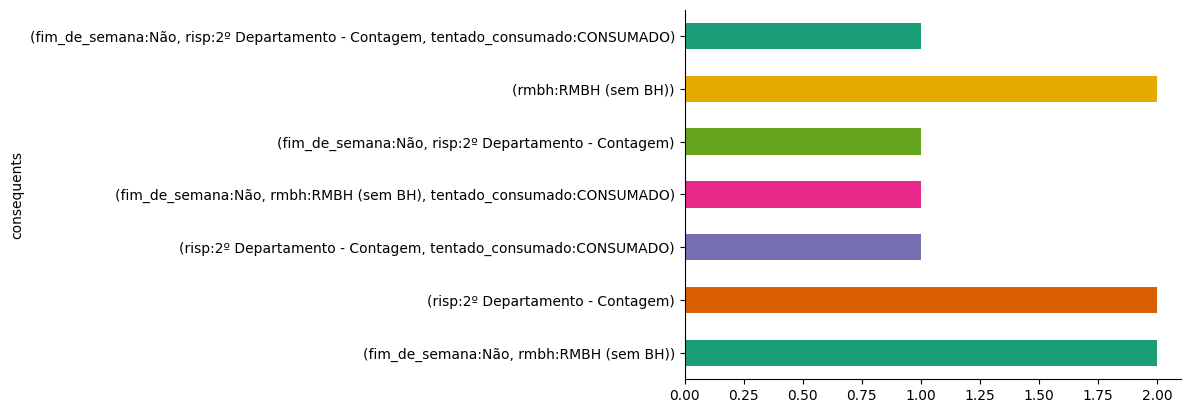

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('consequents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Filtrar e visualizar regras que levam a um crime consumado
print("\n--- Análise Específica: Regras que levam a 'Crime Consumado' ---")

regras_consumado = rules[rules['consequents'] == {'tentado_consumado:CONSUMADO'}]

# Exibe as 10 melhores regras para 'crime consumado', ordenadas por confiança ou lift
display(regras_consumado[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('confidence', ascending=False).head(10))


--- Análise Específica: Regras que levam a 'Crime Consumado' ---


,antecedents,consequents,support,confidence,lift
130,"(rmbh:Interior de MG, natureza_delito:DESCUMPR...",(tentado_consumado:CONSUMADO),0.051401,1.000000,1.009598
129,(natureza_delito:DESCUMPRIMENTO DE MEDIDA PROT...,(tentado_consumado:CONSUMADO),0.065474,1.000000,1.009598
166,"(rmbh:Interior de MG, fim_de_semana:Não, natur...",(tentado_consumado:CONSUMADO),0.078881,0.996919,1.006488
157,"(rmbh:Interior de MG, natureza_delito:LESAO CO...",(tentado_consumado:CONSUMADO),0.139203,0.996510,1.006074
24,"(fim_de_semana:Sim, rmbh:Interior de MG, natur...",(tentado_consumado:CONSUMADO),0.078052,0.996060,1.005620
185,"(fim_de_semana:Sim, rmbh:Interior de MG, natur...",(tentado_consumado:CONSUMADO),0.060322,0.995975,1.005535
162,"(natureza_delito:LESAO CORPORAL, fim_de_semana...",(tentado_consumado:CONSUMADO),0.090874,0.995726,1.005283
150,(natureza_delito:LESAO CORPORAL),(tentado_consumado:CONSUMADO),0.158216,0.995501,1.005056
172,"(fim_de_semana:Sim, natureza_delito:LESAO CORP...",(tentado_consumado:CONSUMADO),0.067343,0.995197,1.004749
20,"(fim_de_semana:Sim, natureza_delito:AMEACA)",(tentado_consumado:CONSUMADO),0.089882,0.994963,1.004513


In [ ]:
# Tentando encontrar regras que levem ao crime de AMEAÇA
regras_ameaca = rules[rules['consequents'] == {'natureza_delito:AMEACA'}]
display(regras_ameaca.sort_values('confidence', ascending=False).head(10))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
36,"(fim_de_semana:Não, rmbh:Interior de MG)",(natureza_delito:AMEACA),0.537848,0.280892,0.164798,0.306402,1.090817,1.0,0.013720,1.036779,0.180149,0.252007,0.035474,0.446548
42,"(fim_de_semana:Não, tentado_consumado:CONSUMAD...",(natureza_delito:AMEACA),0.532355,0.280892,0.162165,0.304619,1.084467,1.0,0.012631,1.034120,0.166553,0.249070,0.032994,0.440970
13,(rmbh:Interior de MG),(natureza_delito:AMEACA),0.820398,0.280892,0.243158,0.296391,1.055176,1.0,0.012715,1.022027,0.291147,0.283358,0.021552,0.581027
17,"(tentado_consumado:CONSUMADO, rmbh:Interior de...",(natureza_delito:AMEACA),0.813069,0.280892,0.240217,0.295445,1.051808,1.0,0.011832,1.020655,0.263499,0.281369,0.020237,0.575319
14,(fim_de_semana:Não),(natureza_delito:AMEACA),0.660751,0.280892,0.190555,0.288392,1.026697,1.0,0.004955,1.010538,0.076649,0.253705,0.010428,0.483392
30,"(fim_de_semana:Não, tentado_consumado:CONSUMADO)",(natureza_delito:AMEACA),0.653942,0.280892,0.187565,0.286822,1.021109,1.0,0.003877,1.008314,0.059738,0.251000,0.008246,0.477284


from matplotlib import pyplot as plt
_df_15['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['antecedent support'].plot(kind='hist', bins=20, title='antecedent support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['confidence'].plot(kind='hist', bins=20, title='confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_19.groupby('antecedents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='index', y='antecedent support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='antecedent support', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='support', y='confidence', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='confidence', y='lift', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['consequent support']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('consequent support', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('antecedents')):
  _plot_series(series, series_name, i)
  fig.legend(title='antecedents', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('consequent support')
_ = plt.ylabel('index')

<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['consequent support']
  ys = series['antecedent support']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('consequent support', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('antecedents')):
  _plot_series(series, series_name, i)
  fig.legend(title='antecedents', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('consequent support')
_ = plt.ylabel('antecedent support')

<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['consequent support']
  ys = series['support']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('consequent support', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('antecedents')):
  _plot_series(series, series_name, i)
  fig.legend(title='antecedents', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('consequent support')
_ = plt.ylabel('support')

<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['consequent support']
  ys = series['confidence']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('consequent support', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('antecedents')):
  _plot_series(series, series_name, i)
  fig.legend(title='antecedents', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('consequent support')
_ = plt.ylabel('confidence')

from matplotlib import pyplot as plt
_df_28['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['antecedent support'].plot(kind='line', figsize=(8, 4), title='antecedent support')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['confidence'].plot(kind='line', figsize=(8, 4), title='confidence')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_32['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_32, x='index', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_33['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_33, x='antecedent support', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_34['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_34, x='support', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_35['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_35, x='confidence', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Tentando encontrar regras que levem a LESAO CORPORAL
regras_lesao = rules[rules['consequents'] == {'natureza_delito:LESAO CORPORAL'}]
display(regras_lesao.sort_values('confidence', ascending=False).head(10))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
184,"(fim_de_semana:Sim, rmbh:Interior de MG, tenta...",(natureza_delito:LESAO CORPORAL),0.280714,0.158931,0.060322,0.214889,1.352090,1.0,0.015708,1.071274,0.362031,0.159027,0.066532,0.297220
178,"(fim_de_semana:Sim, rmbh:Interior de MG)",(natureza_delito:LESAO CORPORAL),0.282550,0.158931,0.060566,0.214356,1.348730,1.0,0.015660,1.070546,0.360390,0.159002,0.065897,0.297720
172,"(fim_de_semana:Sim, tentado_consumado:CONSUMADO)",(natureza_delito:LESAO CORPORAL),0.336551,0.158931,0.067343,0.200097,1.259013,1.0,0.013854,1.051463,0.310087,0.157291,0.048944,0.311909
154,(fim_de_semana:Sim),(natureza_delito:LESAO CORPORAL),0.339249,0.158931,0.067668,0.199463,1.255029,1.0,0.013750,1.050631,0.307537,0.157180,0.048191,0.312615
156,"(tentado_consumado:CONSUMADO, rmbh:Interior de...",(natureza_delito:LESAO CORPORAL),0.813069,0.158931,0.139203,0.171207,1.077239,1.0,0.009981,1.014811,0.383567,0.167151,0.014595,0.523538
152,(rmbh:Interior de MG),(natureza_delito:LESAO CORPORAL),0.820398,0.158931,0.139691,0.170272,1.071354,1.0,0.009304,1.013668,0.370830,0.166370,0.013483,0.524604
150,(tentado_consumado:CONSUMADO),(natureza_delito:LESAO CORPORAL),0.990493,0.158931,0.158216,0.159735,1.005056,1.0,0.000796,1.000956,0.529134,0.159620,0.000955,0.577618


from matplotlib import pyplot as plt
_df_0['antecedent support'].plot(kind='hist', bins=20, title='antecedent support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['confidence'].plot(kind='hist', bins=20, title='confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['lift'].plot(kind='hist', bins=20, title='lift')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('antecedents').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='antecedent support', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='support', y='confidence', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='confidence', y='lift', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='lift', y='leverage', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['antecedent support']
  ys = series['confidence']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('antecedent support', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('antecedents')):
  _plot_series(series, series_name, i)
  fig.legend(title='antecedents', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('antecedent support')
_ = plt.ylabel('confidence')

<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['antecedent support']
  ys = series['lift']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('antecedent support', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('antecedents')):
  _plot_series(series, series_name, i)
  fig.legend(title='antecedents', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('antecedent support')
_ = plt.ylabel('lift')

<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['antecedent support']
  ys = series['leverage']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('antecedent support', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('antecedents')):
  _plot_series(series, series_name, i)
  fig.legend(title='antecedents', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('antecedent support')
_ = plt.ylabel('leverage')

<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
<string>:8: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['antecedent support']
  ys = series['conviction']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('antecedent support', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('antecedents')):
  _plot_series(series, series_name, i)
  fig.legend(title='antecedents', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('antecedent support')
_ = plt.ylabel('conviction')

from matplotlib import pyplot as plt
_df_13['antecedent support'].plot(kind='line', figsize=(8, 4), title='antecedent support')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['confidence'].plot(kind='line', figsize=(8, 4), title='confidence')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['lift'].plot(kind='line', figsize=(8, 4), title='lift')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='antecedent support', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='support', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='confidence', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='lift', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)